In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('paper')

# Using `celerite` to Derive Rotation Velocities

This Notebook provides a simplified example of how one can use the package [`celerite`](http://celerite.readthedocs.io/en/stable/) to model spectra and thus derive a rotational velocity, as described in Teague et al. (2018).

### Background

Optically thin line emission is well described by a Gaussian line profile when the width of the line is dominated by Doppler broadening, as is the case for emission in a protoplanetary disk.

$$T_B(v) = T_B^{\rm peak} \cdot \exp \left[- \frac{(v - v_0)^2}{\Delta V^2}\right]$$

The line centre, $v_0$, describes the systemic velocity of the emitting gas while the line width, $\Delta V$, descibes the velocity dispersion along the line of sight. As the gas within a protoplanetary disk is dominated by the Keplerian rotation around the central star, $v_{\rm Kep}$, the line centres will include a shift relative to the projected rotation velocity,

$$v_0(r,\ \theta) = v_{\rm LSR} - v_{\rm rot}(r) \cdot \cos (\theta)$$

where $\theta$ is the angle measured from the blue-shifted major axis of the disk.

The idea of this method is to assume that the disk is azimuthally symmetric (a reasonable assumption, at least for HD 163296) and such that for a given radius, all emission should have the same intrinsic $\Delta V$ and $T_B$, but with a systematic offset in $v_0$. Thus, by shifting all spectra to $v_{\rm LSR}$ assuming that the rotation is dominated by Keplerian rotation, one can get a significant boost in the signal to noise of your data. See, for example, [Teague et al. (2016)](https://ui.adsabs.harvard.edu/#abs/2016A&A...592A..49T), [Yen et al. (2016)](https://ui.adsabs.harvard.edu/#abs/2016ApJ...832..204Y) and [Matra et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...842....9M).

### Inferring $v_{\rm rot}$ from Width

Although assuming Keplerian rotation is a good first order approximation, we can invert this method to calculate what the profile for $v_{\rm rot}$ should be. For the case of the optically thin line above, we know that within an annulus of constant radius, all the lines should have the same width and hence, also the averaged profile. As $\cos$ is periodic, any under- or over-estimation of $v_{\rm rot}$ would result in a slight scatter in the corrected line centres and subsequently a broadening in the averaged profile. Hence, we assert that for a given radius, $v_{\rm rot}$ is the value which minimizes the width of the averaged profile.

### Relaxing the Assumption of Gaussian Line Profiles

In reality, the Gaussian line profile is only an approximation, and a pretty bad one for optically thick lines like $^{12}{\rm CO}$. As such, simply minimizing the width is not a good idea. Furthermore, we require a model for what the intrinsic line is in order to estimate the uncertainties on $v_{\rm rot}$.

Instead of using an analytical form for the line profile, we can model is with as a Gaussian process. A gentle introduction to Gaussian processes can be found [here](http://betatim.github.io/posts/gaussian-processes-with-george/), while [here](http://adsabs.harvard.edu/abs/2017ApJ...840...49C) is another example of modelling spectra with Gaussian Processes ([with public code too!](https://github.com/iancze/PSOAP)). This assumes that our line profile will be smooth, with the smoothness dictated by some correlation length.

We then search for the rotation velocity which will allow us to genreate a smooth model (with a white noise model included) which minimizes the variance.

### Example

We consider the case where we have extracted spectra which we assume all arise at the same radial location in the disk. We assume a Gaussian line profile, but any profile works the same. Each line has the same properties, dV and Tb, however a line center that is sampled on the interval $[-\pi,\ \pi]$.

While we generate fake data here, one could easily imagine this as the pixels taken from an annulus about the disk centre. `spectra` is of shape `(npix, len(velax))` and `angles` is of size `npix`.

In [1]:
def gaussian(v, dV, Tb, v0):
    """Gaussian line profile."""
    return Tb * np.exp(-np.power((v-v0)/dV, 2))

In [10]:
vrot = 800.
velax = np.arange(-2.0 * vrot, 2.0 * vrot + 1.0, 40.)
velax += np.mean(np.diff(velax)) * np.random.randn()

npix = 8
rms = 0.1
angles = np.linspace(-np.pi, np.pi, npix+1)[:-1]
angles += 1e-3 * np.random.randn(npix)
spectra = gaussian(velax[None, :], 100., 1.0, (np.cos(angles) * vrot)[:, None])
spectra += rms * np.random.randn(spectra.size).reshape(spectra.shape)

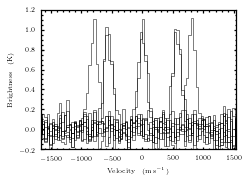

In [11]:
fig, ax = plt.subplots()
for spectrum in spectra:
    ax.step(velax, spectrum, where='mid', color='k', alpha=0.5)
ax.set_xlim(velax.min(), velax.max())
ax.set_ylim(-0.2, 1.2)
ax.set_xlabel(r'${\rm Velocity \quad (m\,s^{-1})}$')
ax.set_ylabel(r'${\rm Brightness \quad (K)}$')

# Non-Parametric Modelling

We use the `EnsembleSampler` from [`emcee`](http://http://dfm.io/emcee/current/) to run the MCMC. While it is best practice not to hide everything in one function, we write a single `log_probability` function which contains the `log_prior` and `log_likelihood` functionaility.

We build line profile from two parts: the noise, modelled with [`JitterTerm`](http://celerite.readthedocs.io/en/stable/python/kernel/#celerite.terms.JitterTerm), and the line, modelled with [`Mattern32Term`](http://celerite.readthedocs.io/en/stable/python/kernel/#celerite.terms.Matern32Term). One can also use [`SHOTerm`](http://celerite.readthedocs.io/en/stable/python/kernel/#celerite.terms.SHOTerm), however testing has shown that there is little difference between the two, except `Mattern32Term` appears to give slightly tighter posterior distributions for $v_{\rm rot}$.

In [12]:
import time
import emcee
import celerite
import corner

def log_probability(theta, spectra, angles, velax, vkep):
    """
    Log likelihood function.
    
    - Input -
    
    theta:    Free parameters of the fit.
    spectra:  Array of spectra to use for the fitting.
    angles:   Relative position angles of each spectrum. Measured
              east-wards of the blue-shifted major axis.
    velax:    Velocity axis.
    vkep:     Estimated Keplerian rotation. Same uits as velax.
    """

    # Unpack the variables.
    vrot, pa, noise_var, lnsigma, lnrho = theta
    
    # Uninformative (flat) priors for deprojection parameters.
    if not 0.8 <= vrot / vkep <= 1.2:
        return -np.inf    
    if abs(pa) > .2:
        return -np.inf
    
    # Uninformative (flat) priors for hyper-parameters of the kernel.
    if noise_var <= 0.0:
        return -np.inf
    if not np.isfinite(lnsigma):
        return -np.inf
    if not np.isfinite(lnrho):
        return -np.inf
    
    # Deproject the model.
    x = velax[None, :] - vrot * np.cos(angles + pa)[:, None]
    if x.shape == spectra.shape:
        x = x.flatten()
    else:
        x = x.T.flatten()
    y = spectra.flatten()
    
    # Remember to sort values.
    args = np.argsort(x)
    x, y = x[args], y[args]
    
    # Generate the kernel.
    noise = celerite.terms.JitterTerm(log_sigma=np.log(noise_var))
    line = celerite.terms.Matern32Term(log_sigma=lnsigma, log_rho=lnrho)
    kernel = noise + line
    
    # Calculate the log-likelihood.
    gp = celerite.GP(kernel, mean=np.nanmean(y), fit_mean=True)
    try:
        gp.compute(x)
    except:
        return -np.inf
    ll = gp.log_likelihood(y, quiet=True)
    return ll if np.isfinite(ll) else -np.inf

In [13]:
# Guess the rotation velocity based on the line peaks.
centers = np.take(velax, np.argmax(spectra, axis=1))
vmin, vmax = centers.min(), centers.max()
vlsr = np.average([vmin, vmax])
vguess = np.average([vlsr - vmin, vmax - vlsr])
print('Initial guess of vrot: %.1f m/s.' % vguess)

# Estimate the noise from line free channels.
noise = np.var([spectra[:20], spectra[-20:]])
print('Initial guess of noise: %.2f K.' % noise)

Initial guess of vrot: 800.0 m/s.
Initial guess of noise: 0.04 K.


In [14]:
# Generate starting positions for the walkers.
# The hyperparameter starting positions were found
# from testing, however with a sufficient burn-in period
# they should converge.

nsteps = 50
nburnin = 200
nwalkers = 200

p0 = np.array([vrot, 1.0, noise, -2.0, 7.0])
ndim = p0.size
p0 = p0[None, :] * (1 + 3e-2 * np.random.randn(nwalkers * ndim).reshape((nwalkers, ndim)))
p0[:, 1] -= 1.0
    
# Run the sampler.
t0 = time.time()
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(spectra, angles, velax, vguess))
_ = sampler.run_mcmc(p0, nburnin+nsteps)
samples = sampler.chain[:, -nsteps:]
samples = samples.reshape((-1, samples.shape[-1]))
print("Fitting took %d seconds." % (time.time() - t0))

Fitting took 26 seconds.
Not bad for 648 x 50000 samples!


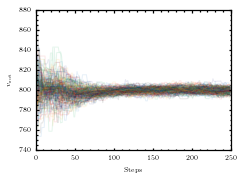

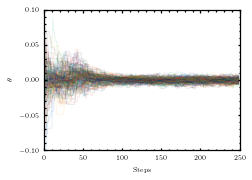

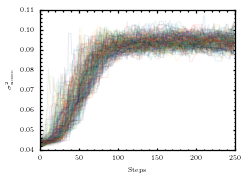

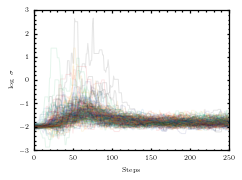

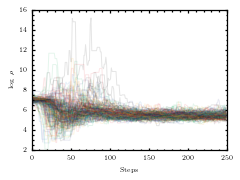

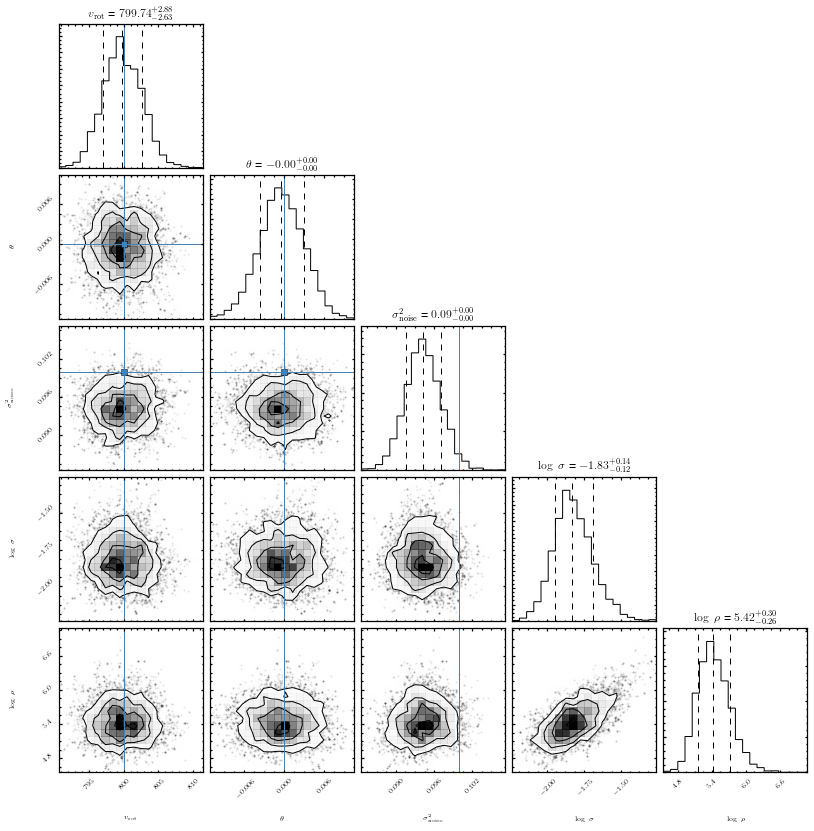

In [15]:
# Labels.
labels=[r'$v_{\rm rot}$', r'$\theta$', r'$\sigma_{\rm noise}^2$', r'$\log~\sigma$', r'$\log~\rho$']

# Plot the samples.
for p in range(ndim):
    fig, ax = plt.subplots()
    for w in range(nwalkers):
        ax.plot(sampler.chain[w, :, p], alpha=0.1)
    ax.set_ylabel(labels[p])
    ax.set_xlabel(r'${\rm Steps}$')
    
# Plot the corner plot.
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], show_titles='True',
                    labels=labels, truths=[vrot, 0.0, rms, None, None])